In [1]:
import os
import pathlib
import warnings

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.ndimage import gaussian_filter

from pyia import GaiaData
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp

from astroquery.gaia import Gaia
Gaia.login(credentials_file=os.path.expanduser('~/.gaia/archive.login'))

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
OK


First get all Gaia column names:

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    col_job = Gaia.launch_job('SELECT TOP 1 * FROM gaiaedr3.gaia_source')
colnames = col_job.get_results().colnames

---

# DR17 beta

In [3]:
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_beta/allStarLite-r13-l33-58932beta.fits')

In [4]:
xm_tablename = 'apogee_beta_58932'

In [5]:
try:
    Gaia.delete_user_table(xm_tablename)
except Exception as e:
    print('ERROR ' + str(e))

500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_apricewh.apogee_beta_58932
. Because: ERROR: table "apogee_beta_58932" does not exist
ERROR Error 500:
Can not execute the following SQL: 
DROP TABLE user_apricewh.apogee_beta_58932
. Because: ERROR: table "apogee_beta_58932" does not exist


Set up sub-table for cross-match:

In [7]:
tmp = allstar['APOGEE_ID', 'RA', 'DEC', 'GAIA_SOURCE_ID']
tmp.rename_column('GAIA_SOURCE_ID', 'source_id')
tmp = at.unique(tmp, keys='APOGEE_ID')
print(len(tmp))

617631


In [8]:
Gaia.upload_table(tmp, table_name=xm_tablename)
Gaia.set_ra_dec_columns(xm_tablename, 'ra', 'dec')

Sending pytable.
Uploaded table 'apogee_beta_58932'.


"Table 'apogee_beta_58932' updated (ra/dec)."

Perform initial cross-match:

In [9]:
tmass_epoch = 1999. # the mean 2MASS epoch, apparently
init_radius = 20 * u.arcsec
after_radius = 4 * u.arcsec
colnames_str = ", ".join(['subq.' + x for x in colnames])
# colnames_str = 'subq.source_id, subq.ra, subq.dec, subq.phot_g_mean_mag, subq.phot_bp_mean_mag, subq.phot_rp_mean_mag'

q = f'''SELECT subq.apogee_id, {colnames_str}
FROM (
    SELECT apogee.apogee_id, apogee.ra as apogee_ra, apogee.dec as apogee_dec, gaia.*
    FROM user_apricewh.{xm_tablename} AS apogee, gaiaedr3.gaia_source as gaia
    WHERE 
        contains(POINT('ICRS', apogee.ra, apogee.dec),
                 CIRCLE('ICRS', gaia.ra, gaia.dec, {init_radius.to_value(u.deg):.5f}))=1
    OFFSET 0
) AS subq
WHERE 
    contains(POINT('ICRS', subq.ra + subq.pmra / 3600e3  * ({tmass_epoch:.1f} - subq.ref_epoch) / COS(RADIANS(subq.dec)), 
                           subq.dec + subq.pmdec / 3600e3 * ({tmass_epoch:.1f} - subq.ref_epoch)),
             CIRCLE('ICRS', subq.apogee_ra, subq.apogee_dec, {after_radius.to_value(u.deg):.5f}))=1

'''
print(q)

SELECT subq.apogee_id, subq.solution_id, subq.designation, subq.source_id, subq.random_index, subq.ref_epoch, subq.ra, subq.ra_error, subq.dec, subq.dec_error, subq.parallax, subq.parallax_error, subq.parallax_over_error, subq.pm, subq.pmra, subq.pmra_error, subq.pmdec, subq.pmdec_error, subq.ra_dec_corr, subq.ra_parallax_corr, subq.ra_pmra_corr, subq.ra_pmdec_corr, subq.dec_parallax_corr, subq.dec_pmra_corr, subq.dec_pmdec_corr, subq.parallax_pmra_corr, subq.parallax_pmdec_corr, subq.pmra_pmdec_corr, subq.astrometric_n_obs_al, subq.astrometric_n_obs_ac, subq.astrometric_n_good_obs_al, subq.astrometric_n_bad_obs_al, subq.astrometric_gof_al, subq.astrometric_chi2_al, subq.astrometric_excess_noise, subq.astrometric_excess_noise_sig, subq.astrometric_params_solved, subq.astrometric_primary_flag, subq.nu_eff_used_in_astrometry, subq.pseudocolour, subq.pseudocolour_error, subq.ra_pseudocolour_corr, subq.dec_pseudocolour_corr, subq.parallax_pseudocolour_corr, subq.pmra_pseudocolour_corr, sub

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q, name='APOGEE_beta_58932_EDR3')

INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
res = job.get_results()

for col in res.colnames:
    if res[col].dtype == object:
        print(col)
        res[col] = res[col].astype(str)
        
res.rename_column('apogee_id', 'APOGEE_ID')
res = at.unique(res, keys=['APOGEE_ID', 'source_id'])

apogee_id
designation


In [12]:
len(tmp), len(res)

(617631, 763747)

Clearly there are cases where multiple Gaia sources match to each APOGEE source. For cases where multiple sources match, take the brightest (in RP) Gaia source:

In [13]:
df = res['APOGEE_ID', 'phot_rp_mean_mag'].to_pandas()
df['phot_rp_mean_mag'] = df['phot_rp_mean_mag'].fillna(9999.)
idx = df.groupby('APOGEE_ID')['phot_rp_mean_mag'].idxmin().values.astype('i8')

Join the results:

In [14]:
unq_res = res[idx]
joined = at.join(unq_res, allstar, keys='APOGEE_ID')
joined = at.unique(joined, keys=('APOGEE_ID', 'source_id'))

In [15]:
len(tmp), len(df), len(idx), len(joined)

(617631, 763747, 606940, 606940)

In [19]:
unq_res.write('/mnt/home/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta-gaiaedr3-xmatch.fits',
              overwrite=True)

In [20]:
joined.write('/mnt/home/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta-gaiaedr3.fits',
             overwrite=True)

Compare this crossmatch to the DR16 DR2 crossmatch

In [16]:
allstar['phot_bp_mean_mag'] = allstar['GAIA_PHOT_BP_MEAN_MAG']
allstar['phot_rp_mean_mag'] = allstar['GAIA_PHOT_RP_MEAN_MAG']
allstar['phot_g_mean_mag'] = allstar['GAIA_PHOT_G_MEAN_MAG']

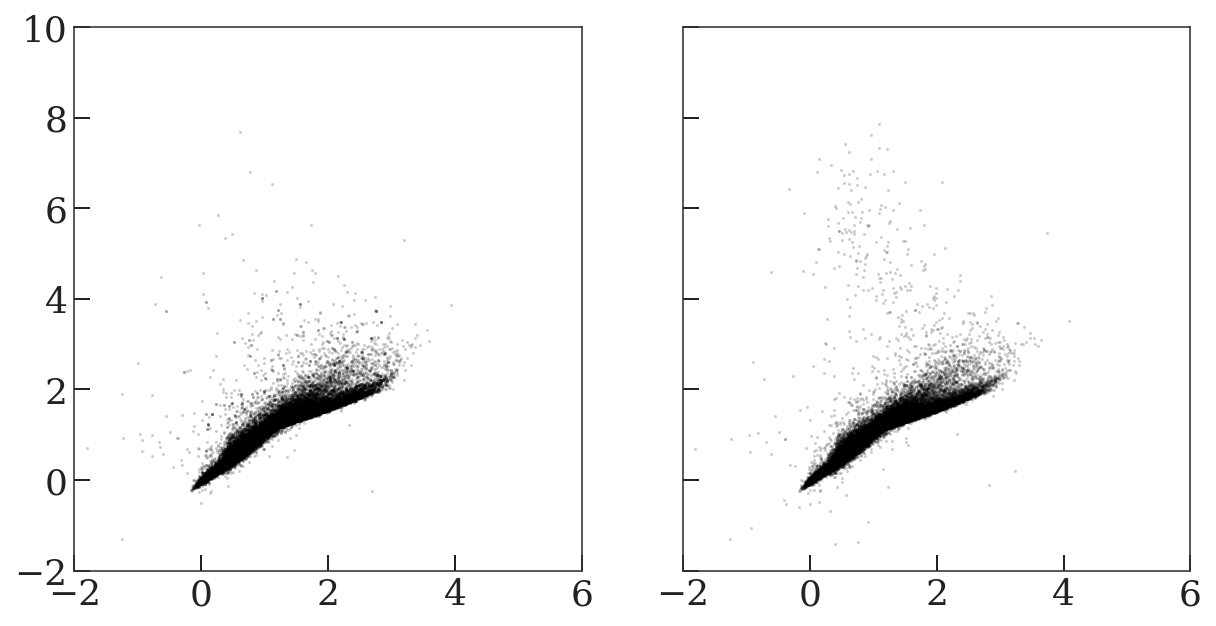

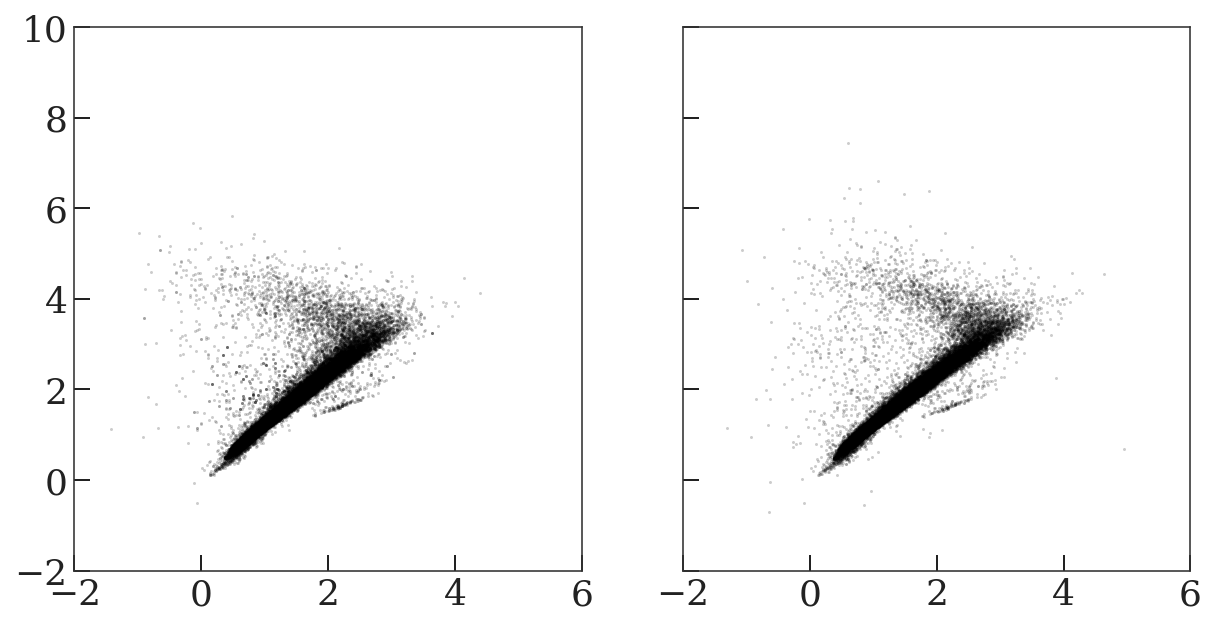

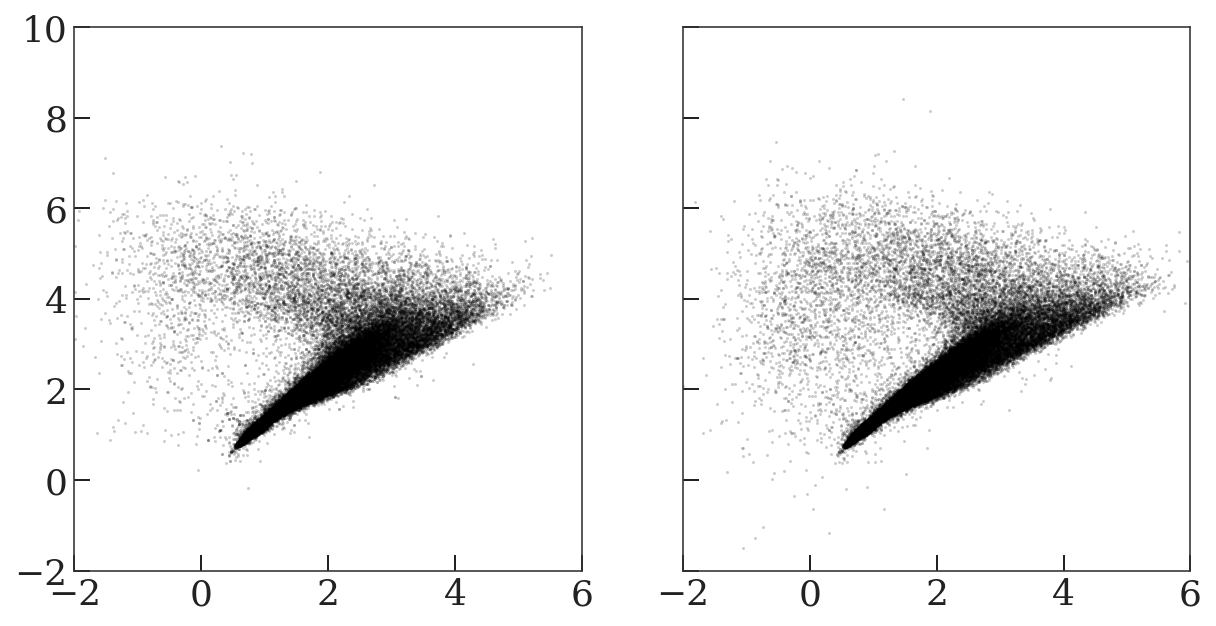

In [17]:
for l, r in [(3.5, 5.5), (2, 3.5), (-0.5, 2)]:    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                             sharex=True, sharey=True)
    
    for ax, cat in zip(axes, [allstar, joined]):
        logg_mask = (cat['LOGG'] > l) & (cat['LOGG'] <= r)
        dcolor = (cat['phot_bp_mean_mag'] - cat['phot_rp_mean_mag']) - (cat['J'] - cat['H'])
        ax.plot(
            dcolor[logg_mask],
            (cat['phot_rp_mean_mag'] - cat['J'])[logg_mask],
            alpha=0.2, marker='o', ms=1.5, mew=0, ls='none')       
        
    ax.set_xlim(-2, 6)
    ax.set_ylim(-2, 10)

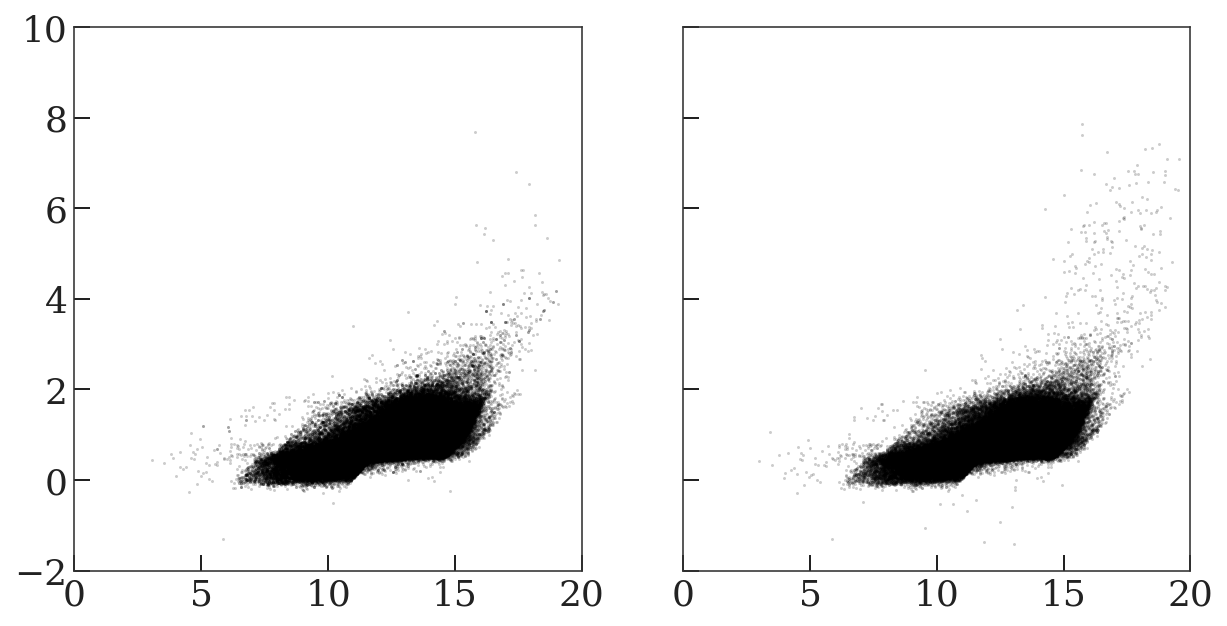

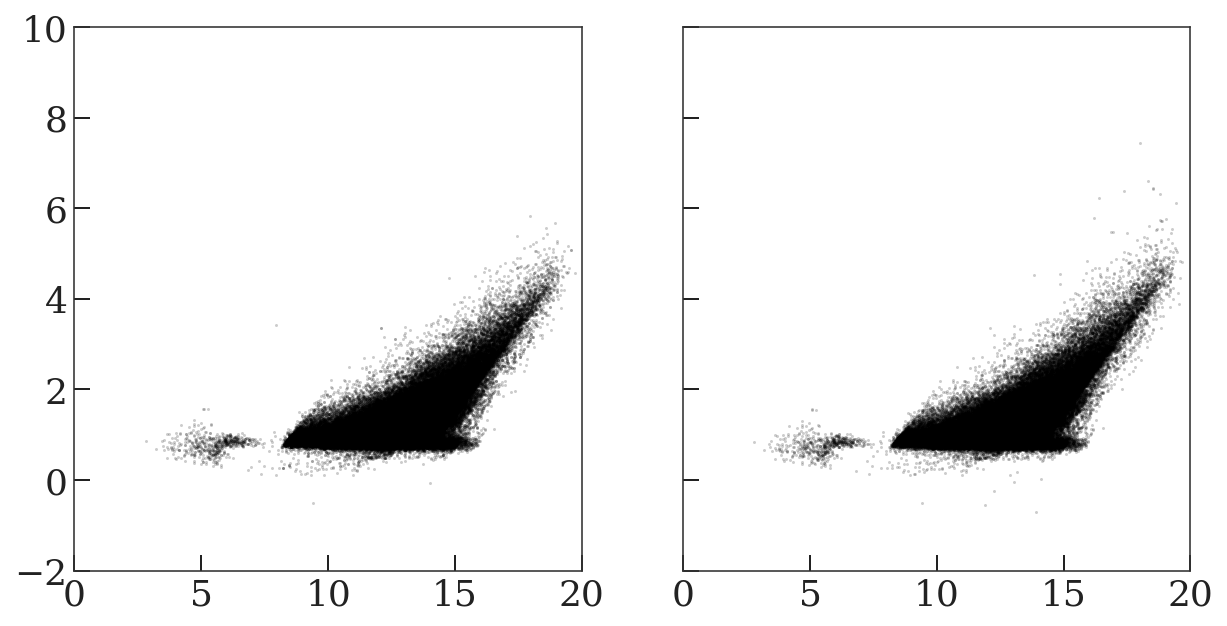

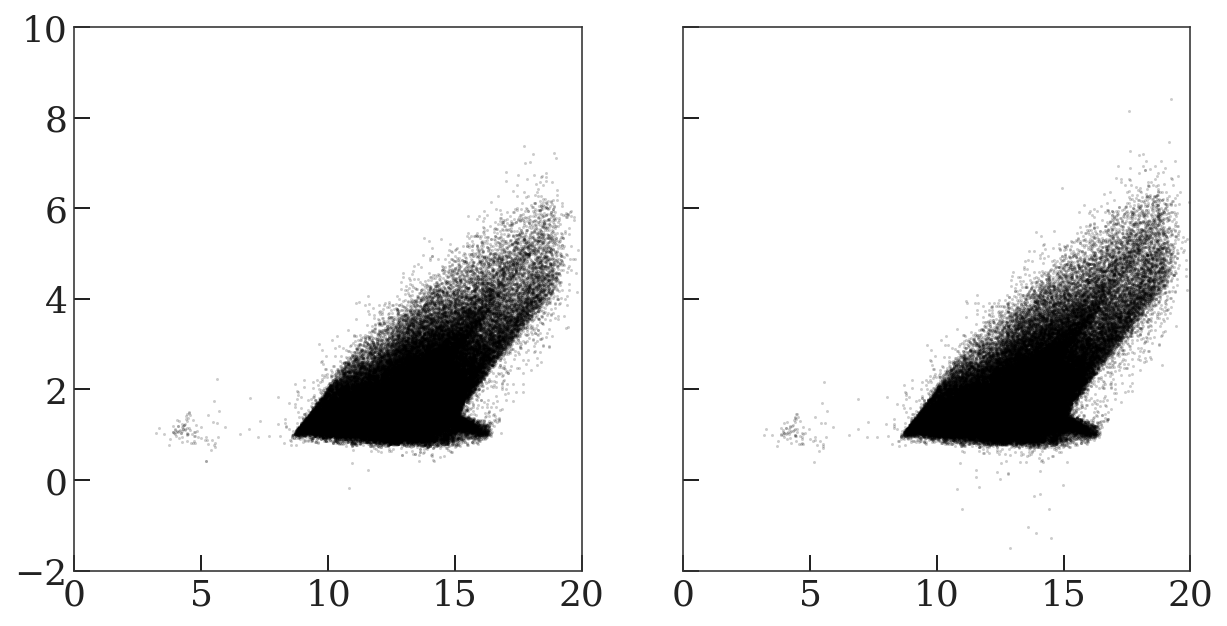

In [18]:
for l, r in [(3.5, 5.5), (2, 3.5), (-0.5, 2)]:    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                             sharex=True, sharey=True)
    
    for ax, cat in zip(axes, [allstar, joined]):
        logg_mask = (cat['LOGG'] > l) & (cat['LOGG'] <= r)
        ax.plot(
            cat['phot_rp_mean_mag'][logg_mask], 
            (cat['phot_rp_mean_mag'] - cat['J'])[logg_mask],
            alpha=0.2, marker='o', ms=1.5, mew=0, ls='none')
        
    ax.set_xlim(0, 20)
    ax.set_ylim(-2, 10)